# How to run basic GP regression


In [ ]:
!pip install git+ssh://git@github.com/UncertaintyInComplexSystems/bayesianmodels.git
!pip install numpy==1.23.5

Import the necessary stuff:

In [3]:
import matplotlib.pyplot as plt

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

Simulate some data from a known GP so we can look at the inference of the hyperparameters):

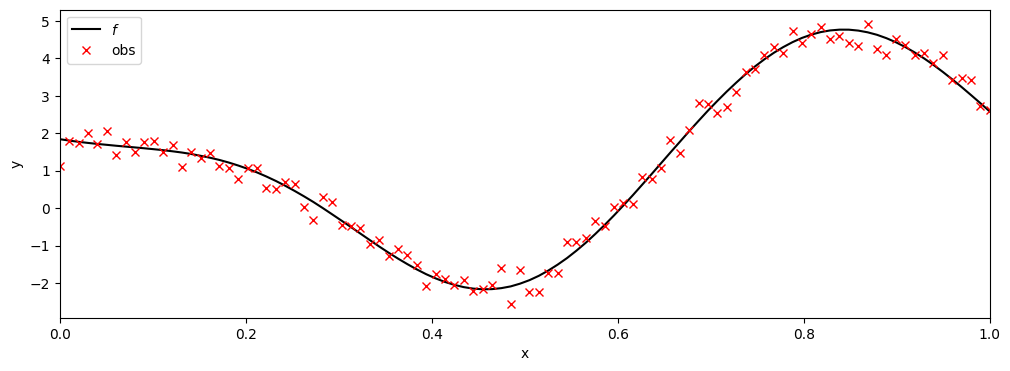

In [22]:
key = jrnd.PRNGKey(12345)

lengthscale_ = 0.2
output_scale_ = 5.0
obs_noise_ = 0.3
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

kernel = jk.RBF()
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_),
                            x=x, y=x) + 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'$f$')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

Set up the GP models, either with $\mathbf{f}$ sampled explicitly, or with $\mathbf{f}$ margnalized out (theobvious choice for a Gaussian likelihood, but sampling is shown for pedagogical reasons):

In [23]:
priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp())),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())))

gp_marginal = FullMarginalGPModel(x, y, cov_fn=jk.RBF(), priors=priors)  # Implies likelihood=Gaussian()
gp_latent = FullLatentGPModel(x, y, cov_fn=jk.RBF(), priors=priors)  # Defaults to likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

Run inference:

In [24]:
%%time

key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

CPU times: user 9.11 s, sys: 3.79 s, total: 12.9 s
Wall time: 13.2 s


In [25]:
%%time

key, gpl_key = jrnd.split(key)
lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpl_key,
                                                                mode='gibbs-in-smc',
                                                                sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

CPU times: user 14 s, sys: 59.6 ms, total: 14.1 s
Wall time: 15.7 s


Plot posteriors of hyperparameters for both models:

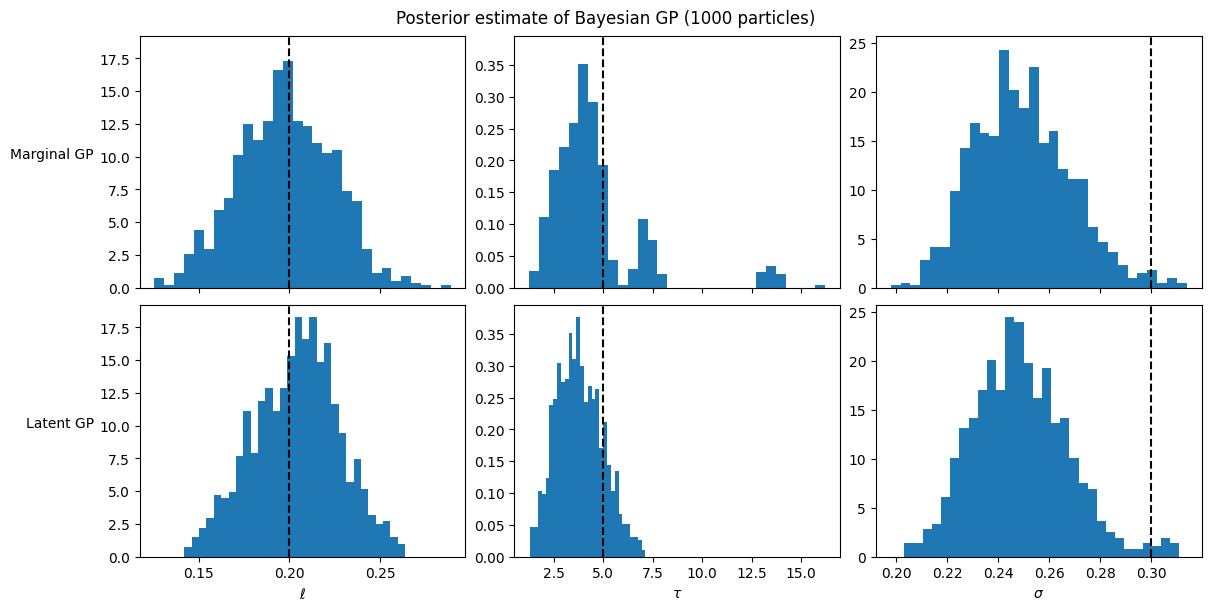

In [26]:
trainables = list()
for component, val in priors.items():
    trainables.extend(list(val.keys()))


num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])

symbols = dict(lengthscale='\ell',
               obs_noise='\sigma',
               variance=r'\tau')

_, axes = plt.subplots(nrows=2, ncols=num_params, constrained_layout=True,
                       sharex='col', sharey='col', figsize=(12, 6))

for m, particles in enumerate([mgp_particles, lgp_particles]):
    for j, var in enumerate(trainables):
        ax = axes[m, j]
        pd = particles.particles[var]
        # There are some outliers that skew the axis
        pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
        pd_filtered = jnp.extract(pd>pd_l, pd)
        pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
        ax.hist(pd_filtered, bins=30, density=True, color='tab:blue')
        if var in symbols and m==1:
            ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right')

if len(ground_truth):
    for j, var in enumerate(trainables):
        axes[0, j].axvline(x=ground_truth[var], ls='--', c='k');
        axes[1, j].axvline(x=ground_truth[var], ls='--', c='k');

And plot the posterior predictive of $\mathbf{f}$:

CPU times: user 6.06 s, sys: 735 ms, total: 6.79 s
Wall time: 9.19 s


Text(0, 0.5, 'Latent GP')

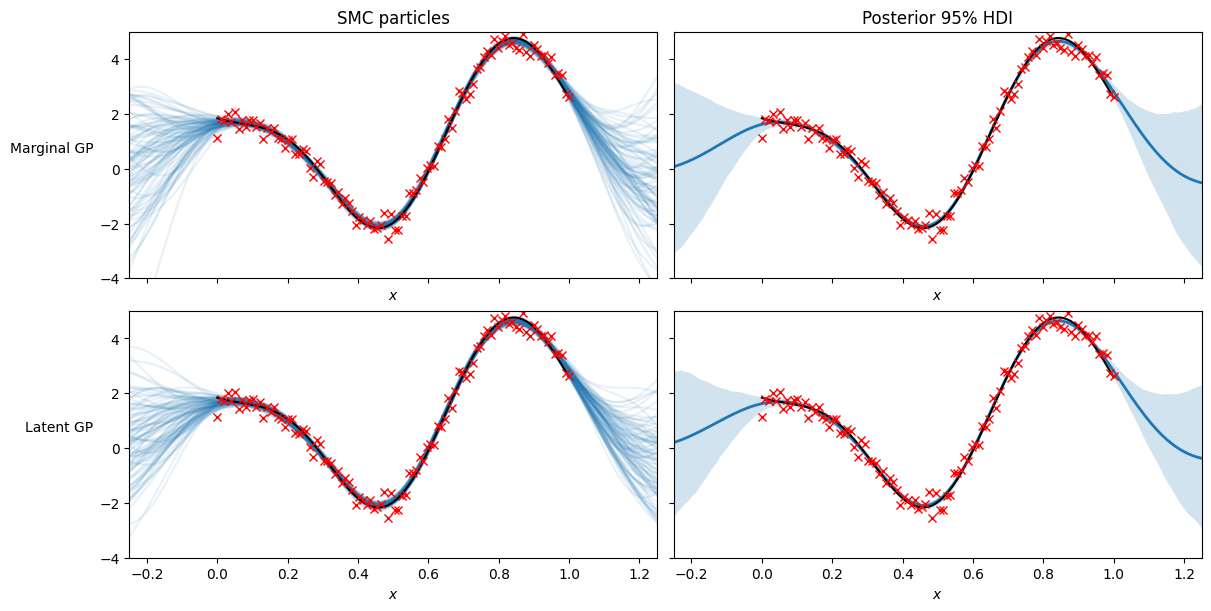

In [28]:
%%time

x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True,
                            sharey=True, constrained_layout=True)

for j, gp in enumerate([gp_marginal, gp_latent]):
    key, key_pred = jrnd.split(key)
    f_pred = gp.predict_f(key_pred, x_pred)

    ax = axes[j, 0]
    for i in jnp.arange(0, num_particles, step=10):
        ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

    ax = axes[j, 1]
    f_mean = jnp.mean(f_pred, axis=0)
    f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

    ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
    ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                    alpha=0.2, color='tab:blue', lw=0)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-4., 5.])
    ax.set_xlabel(r'$x$')

axes[0, 0].set_title('SMC particles')
axes[0, 1].set_title('Posterior 95% HDI')

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right');